# CMIP5 LOCA: Precipitation and Temperature Ensembles

Plot and otherwise examine the LOCA  ensembles. There should be 64 time series. Temperature is daily average temperature calculated from daily maximum and daily minimum temperature. Ensembles are examined for grid cell 92.

# Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns
from scipy.signal import butter, lfilter, freqz, sosfilt
from copy import deepcopy

In [3]:
# changes so Source Sans Pro used in plots and so fonts are not embedded as paths
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'SourceSansPro-Regular'

In [4]:
IN_DIR = r'C:\Users\nmart\Dropbox\MyPapers\CC_WeatherGen\Data\LOCA_Ensembles'
OUT_DIR = r'C:\Users\nmart\Documents\CC_Plots'

In [5]:
CQuants = [ 0.05, 0.25, 0.50, 0.75, 0.95 ]

In [6]:
SM_NUM = 5

In [7]:
# time periods
TP_DICT = { 1 : [ dt.datetime(1981, 1, 1), dt.datetime(2010, 12, 31)],
            2 : [ dt.datetime(2011, 1, 1), dt.datetime(2040, 12, 31)],
            3 : [ dt.datetime(2041, 1, 1), dt.datetime(2070, 12, 31)],
            4 : [ dt.datetime(2071, 1, 1), dt.datetime(2100, 12, 31)],}

## Load the Models Table

In [8]:
Infiler = os.path.normpath( os.path.join( IN_DIR, "AllModelsTable.pickle" ) )
ModDF = pd.read_pickle( Infiler )

In [9]:
#display( HTML( ModDF.to_html() ) )

## Load Precipitation and Temperature Ensembles

In [10]:
Infiler = os.path.normpath( os.path.join( IN_DIR, "Precip_TS_LOCA-92_1981-2100.pickle") )
PreDF = pd.read_pickle( Infiler )

In [11]:
display( HTML( PreDF.head().to_html() ))

,M1_92,M2_92,M3_92,M4_92,M5_92,M6_92,M7_92,M8_92,M9_92,M10_92,M11_92,M12_92,M13_92,M14_92,M15_92,M16_92,M17_92,M18_92,M19_92,M20_92,M21_92,M22_92,M23_92,M24_92,M25_92,M26_92,M27_92,M28_92,M29_92,M30_92,M31_92,M32_92,M33_92,M34_92,M35_92,M36_92,M37_92,M38_92,M39_92,M40_92,M41_92,M42_92,M43_92,M44_92,M45_92,M46_92,M47_92,M48_92,M49_92,M50_92,M51_92,M52_92,M53_92,M54_92,M55_92,M56_92,M57_92,M58_92,M59_92,M60_92,M61_92,M62_92,M63_92,M64_92
Datetime_UTC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-01-01,0.000000,0.0,0.056966,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.919788,0.0,0.494441,0.0,0.834121,0.0,0.0,0.182292,0.0,0.0,0.0,2.105862,0.000000,0.00000,0.471113,0.0,0.0,0.062887,0.0,0.000000,0.000000,0.0,0.056966,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.919788,0.0,0.494441,0.0,0.834121,0.0,0.0,0.182292,0.0,0.0,0.0,2.105862,0.000000,0.00000,0.471113,0.0,0.0,0.062887,0.0,0.000000
1981-01-02,1.697193,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,13.752034,0.0,1.693538,0.0,0.152302,0.0,0.0,5.778620,0.0,0.0,0.0,1.836264,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.697193,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,13.752034,0.0,1.693538,0.0,0.152302,0.0,0.0,5.778620,0.0,0.0,0.0,1.836264,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1981-01-03,0.132270,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.158475,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.257189,0.000000,0.00000,0.281931,0.0,0.0,0.000000,0.0,0.000000,0.132270,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.158475,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.257189,0.000000,0.00000,0.281931,0.0,0.0,0.000000,0.0,0.000000
1981-01-04,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.046418,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.063853,0.008413,0.00000,0.760813,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.046418,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.063853,0.008413,0.00000,0.760813,0.0,0.0,0.000000,0.0,0.000000
1981-01-05,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.55892,0.000000,0.0,0.0,0.000000,0.0,0.162336,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.55892,0.000000,0.0,0.0,0.000000,0.0,0.162336


In [12]:
Infiler = os.path.normpath( os.path.join( IN_DIR, "AveTemp_TS_LOCA-92_1981-2100.pickle") )
TempDF = pd.read_pickle( Infiler )

In [13]:
display( HTML( TempDF.head().to_html() ))

,M1_92,M2_92,M3_92,M4_92,M5_92,M6_92,M7_92,M8_92,M9_92,M10_92,M11_92,M12_92,M13_92,M14_92,M15_92,M16_92,M17_92,M18_92,M19_92,M20_92,M21_92,M22_92,M23_92,M24_92,M25_92,M26_92,M27_92,M28_92,M29_92,M30_92,M31_92,M32_92,M33_92,M34_92,M35_92,M36_92,M37_92,M38_92,M39_92,M40_92,M41_92,M42_92,M43_92,M44_92,M45_92,M46_92,M47_92,M48_92,M49_92,M50_92,M51_92,M52_92,M53_92,M54_92,M55_92,M56_92,M57_92,M58_92,M59_92,M60_92,M61_92,M62_92,M63_92,M64_92
Datetime_UTC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-01-01,7.026285,11.773798,14.425806,12.680429,3.774133,10.556635,0.942011,4.995813,-1.306387,8.627390,4.544199,1.740869,15.861628,4.375986,2.771631,10.519922,8.855432,7.750864,3.802149,10.247431,6.131372,5.788767,8.295664,4.255487,9.072595,2.991693,3.338525,12.038934,11.556391,5.739694,12.272089,4.676142,7.026285,11.773798,14.425806,12.680429,3.774133,10.556635,0.942011,4.995813,-1.306387,8.627390,4.544199,1.740869,15.861628,4.375986,2.771631,10.519922,8.855432,7.750864,3.802149,10.247431,6.131372,5.788767,8.295664,4.255487,9.072595,2.991693,3.338525,12.038934,11.556391,5.739694,12.272089,4.676142
1981-01-02,10.369989,11.631189,6.366724,11.131006,5.584238,12.342996,4.701502,3.458185,-1.055395,4.417093,6.476145,2.211756,6.883722,5.779627,6.391580,14.959970,10.046930,6.166254,5.436182,6.226908,6.970362,6.641382,5.763330,12.635370,7.760324,3.594461,6.695185,12.549143,11.846201,9.036264,11.335428,4.172098,10.369989,11.631189,6.366724,11.131006,5.584238,12.342996,4.701502,3.458185,-1.055395,4.417093,6.476145,2.211756,6.883722,5.779627,6.391580,14.959970,10.046930,6.166254,5.436182,6.226908,6.970362,6.641382,5.763330,12.635370,7.760324,3.594461,6.695185,12.549143,11.846201,9.036264,11.335428,4.172098
1981-01-03,6.760263,6.416818,0.906244,11.418711,7.745371,14.727884,7.394129,0.113138,-3.607886,5.570184,5.196039,5.363977,-2.464392,8.521341,1.862817,15.694666,6.027643,3.405435,8.413095,3.461832,10.127329,10.100656,7.546121,16.124964,9.912760,3.821207,8.175272,11.843698,12.716196,11.329096,4.124246,5.777353,6.760263,6.416818,0.906244,11.418711,7.745371,14.727884,7.394129,0.113138,-3.607886,5.570184,5.196039,5.363977,-2.464392,8.521341,1.862817,15.694666,6.027643,3.405435,8.413095,3.461832,10.127329,10.100656,7.546121,16.124964,9.912760,3.821207,8.175272,11.843698,12.716196,11.329096,4.124246,5.777353
1981-01-04,5.233347,12.214792,2.415751,7.625559,9.366342,11.707590,7.037851,3.754816,-2.914541,9.692346,4.207056,5.512293,-1.193762,10.060083,3.255655,15.862924,9.876154,6.410150,10.921305,4.871103,12.890589,11.557535,11.036646,13.346216,7.316126,8.510889,14.832941,3.402200,14.194345,10.256754,3.597727,1.961191,5.233347,12.214792,2.415751,7.625559,9.366342,11.707590,7.037851,3.754816,-2.914541,9.692346,4.207056,5.512293,-1.193762,10.060083,3.255655,15.862924,9.876154,6.410150,10.921305,4.871103,12.890589,11.557535,11.036646,13.346216,7.316126,8.510889,14.832941,3.402200,14.194345,10.256754,3.597727,1.961191
1981-01-05,4.589624,13.408579,7.462122,4.879831,11.137537,4.199747,4.839136,1.925165,-5.308127,12.021433,4.782160,6.286096,0.126611,13.299677,5.098261,15.329950,14.143213,6.673487,13.308359,5.741312,12.675546,8.365152,13.843775,12.962091,3.086542,13.694834,9.551645,-0.516928,6.563974,3.729395,4.275659,3.022913,4.589624,13.408579,7.462122,4.879831,11.137537,4.199747,4.839136,1.925165,-5.308127,12.021433,4.782160,6.286096,0.126611,13.299677,5.098261,15.329950,14.143213,6.673487,13.308359,5.741312,12.675546,8.365152,13.843775,12.962091,3.086542,13.694834,9.551645,-0.516928,6.563974,3.729395,4.275659,3.022913


## Processing

In [14]:
AllCols = list( PreDF.columns )
ModelInds = [ int( (x.split("_")[0]).strip("M") ) for x in AllCols ]
MScenario = [ ModDF.at[x,"Scenario_ID"] for x in ModelInds ]
ModelName = [ ModDF.at[x,"CMIP5_Model"] for x in ModelInds ]

### Precipitation

Get annual values using sum

In [15]:
PAnnDF = PreDF.resample( 'AS', closed='left', label='left').sum()
PAnnDF["Year"] = PAnnDF.index.year

In [16]:
del PreDF

In [17]:
AllYrsList = PAnnDF["Year"].tolist()
PyDTList = [ dt.datetime( x, 7, 1 ) for x in AllYrsList ]
MidYrIndexer = pd.DatetimeIndex( data=PyDTList, freq='infer' )

Create a new DataFrame using the annual values, the new mid-year index and enhanced column names

In [18]:
TotLen = len( PAnnDF )
TotLen

119

In [19]:
tCnt = 0
PADDict = dict()
PS45Dict = dict()
PS85Dict = dict()
ValueBigList = list()
for tCol in AllCols:
    tScen = MScenario[tCnt]
    tMod = ModelName[tCnt]
    if tCnt == 0:
        ScenarioBigList = [ tScen for x in range(TotLen) ]
        ModelBigList = [ tMod for x in range(TotLen) ]
        ValueBigList.append( PAnnDF[tCol].to_numpy() )
        ParamBigList = [ "annual precipitation depth" for x in range(TotLen) ]
        DTBigList= list( MidYrIndexer.to_pydatetime() )
    else:
        ScenarioBigList.extend( [ tScen for x in range(TotLen) ] )
        ModelBigList.extend( [ tMod for x in range(TotLen) ] )
        ValueBigList.append( PAnnDF[tCol].to_numpy() )
        ParamBigList.extend( [ "annual precipitation depth" for x in range(TotLen) ] )
        DTBigList.extend( list( MidYrIndexer.to_pydatetime() ) )
    if tScen == "rcp45":
        PS45Dict[ModelName[tCnt]] = PAnnDF[tCol].to_numpy()
    elif tScen == "rcp85":
        PS85Dict[ModelName[tCnt]] = PAnnDF[tCol].to_numpy()
    else:
        print("Unrecognized scenario %s" % tScen )
    # end if
    tLabel = "%s__%s" % ( ModelName[tCnt], tScen )
    PADDict[tLabel] = PAnnDF[tCol].to_numpy()
    tCnt += 1
# end for
PFAnnDF = pd.DataFrame( index=MidYrIndexer, data=PADDict )
PAnn45DF = pd.DataFrame( index=MidYrIndexer, data=PS45Dict ) 
PAnn85DF = pd.DataFrame( index=MidYrIndexer, data=PS85Dict )
# make the seaborn DF
AllValues = np.concatenate( ValueBigList, axis=0 )
DataDict = { "Date" : DTBigList,
             "Model" : ModelBigList,
             "Scenario" : ScenarioBigList, 
             "Parameter" : ParamBigList,
             "Value" : AllValues, }
sbPrecipDF = pd.DataFrame( data=DataDict )

In [20]:
display( HTML( sbPrecipDF.head().to_html() ) )

,Date,Model,Scenario,Parameter,Value
0,1981-07-01,access1-0,rcp45,annual precipitation depth,618.100093
1,1982-07-01,access1-0,rcp45,annual precipitation depth,466.903635
2,1983-07-01,access1-0,rcp45,annual precipitation depth,503.537033
3,1984-07-01,access1-0,rcp45,annual precipitation depth,471.567100
4,1985-07-01,access1-0,rcp45,annual precipitation depth,289.162608


In [21]:
len( sbPrecipDF ), 64 * TotLen

(7616, 7616)

In [22]:
len( list( PAnn45DF.columns ) ), len( list( PAnn85DF.columns ) )

(32, 32)

In [23]:
display( HTML( PFAnnDF.describe().to_html() ) )

,access1-0__rcp45,access1-3__rcp45,bcc-csm1-1__rcp45,bcc-csm1-1-m__rcp45,canesm2__rcp45,ccsm4__rcp45,cesm1-bgc__rcp45,cesm1-cam5__rcp45,cmcc-cm__rcp45,cnrm-cm5__rcp45,csiro-mk3-6-0__rcp45,ec-earth__rcp45,fgoals-g2__rcp45,gfdl-cm3__rcp45,gfdl-esm2g__rcp45,gfdl-esm2m__rcp45,giss-e2-r__rcp45,hadgem2-ao__rcp45,hadgem2-cc__rcp45,hadgem2-es__rcp45,inmcm4__rcp45,ipsl-cm5a-lr__rcp45,ipsl-cm5a-mr__rcp45,miroc-esm__rcp45,miroc-esm-chem__rcp45,miroc5__rcp45,mpi-esm-lr__rcp45,mpi-esm-mr__rcp45,mri-cgcm3__rcp45,noresm1-m__rcp45,cmcc-cms__rcp45,giss-e2-h__rcp45,access1-0__rcp85,access1-3__rcp85,bcc-csm1-1__rcp85,bcc-csm1-1-m__rcp85,canesm2__rcp85,ccsm4__rcp85,cesm1-bgc__rcp85,cesm1-cam5__rcp85,cmcc-cm__rcp85,cnrm-cm5__rcp85,csiro-mk3-6-0__rcp85,ec-earth__rcp85,fgoals-g2__rcp85,gfdl-cm3__rcp85,gfdl-esm2g__rcp85,gfdl-esm2m__rcp85,giss-e2-r__rcp85,hadgem2-ao__rcp85,hadgem2-cc__rcp85,hadgem2-es__rcp85,inmcm4__rcp85,ipsl-cm5a-lr__rcp85,ipsl-cm5a-mr__rcp85,miroc-esm__rcp85,miroc-esm-chem__rcp85,miroc5__rcp85,mpi-esm-lr__rcp85,mpi-esm-mr__rcp85,mri-cgcm3__rcp85,noresm1-m__rcp85,cmcc-cms__rcp85,giss-e2-h__rcp85
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,535.323830,543.480264,479.551043,498.909099,484.015757,506.292398,514.878458,504.408908,507.434857,507.092827,552.082668,540.598768,502.539076,497.537919,455.108979,546.417261,490.778343,472.320575,481.345773,510.879587,502.885312,430.058190,452.699764,547.012644,488.358133,499.372105,466.057348,488.973441,524.414310,496.969044,455.292358,475.605383,523.166982,528.909922,407.055878,505.853024,501.412883,511.972843,532.735607,512.696718,455.544362,513.783992,501.178320,532.723361,480.561236,487.603814,467.891004,513.661676,491.595657,506.373467,481.829616,487.276919,480.578702,447.384555,412.621433,534.632163,496.908187,484.978628,471.868777,480.165530,501.741274,488.822225,454.850991,473.072896
std,181.170910,191.403817,149.957037,150.130742,132.144811,152.308589,159.778096,165.624002,188.164696,154.396782,182.270470,170.083449,153.344623,140.140696,154.180869,183.717934,145.645697,169.317980,155.820004,158.130501,178.747492,162.110136,190.560711,158.987486,165.716053,174.360430,164.210805,182.960243,156.695116,147.083682,173.731049,158.852870,176.159459,175.078277,925.141976,160.894367,148.733554,144.837090,162.730236,164.168538,144.516189,139.877679,148.982246,198.407614,142.293663,149.521655,159.160078,194.169194,135.748705,178.795363,160.356547,154.271032,174.010714,181.816293,158.199341,164.491523,168.492853,152.060215,172.941755,160.109499,148.430853,156.177840,148.450671,153.752177
min,175.224408,196.668131,157.591278,129.165038,240.351773,218.675459,198.487151,178.489900,127.088612,263.684165,223.943788,195.533145,226.775607,186.087939,101.309188,109.562204,186.553305,186.609910,213.317671,218.998065,196.159907,186.115530,158.674475,222.022848,198.645410,178.379660,102.542847,92.148225,237.319942,106.952651,124.820557,208.629976,178.737973,230.072156,-9450.228056,224.292839,240.351773,239.380131,245.199820,182.535543,106.279608,278.958978,199.616124,233.570934,249.440936,168.517512,118.783532,149.651901,186.553305,220.834130,160.622742,160.080305,144.951172,93.798401,143.522804,141.692470,181.605827,186.620320,145.234111,123.940740,229.313497,185.190689,156.471840,164.200389
25%,396.637809,415.643733,368.192817,399.566464,389.185907

Calculate some basic percentile stats for envelope plotting

In [24]:
StatsHdr = list()
for tQ in CQuants:
    cSHdr = "perc_%4.2f" % tQ
    StatsHdr.append( cSHdr )
    PFAnnDF[cSHdr] = PFAnnDF.quantile( tQ, axis=1 )
    PAnn45DF[cSHdr] = PAnn45DF.quantile( tQ, axis=1 )
    PAnn85DF[cSHdr] = PAnn85DF.quantile( tQ, axis=1 )
# end for
StatsHdr.append("mean")
PFAnnDF["mean"] = PFAnnDF.mean( axis=1 )
PAnn45DF["mean"] = PAnn45DF.mean( axis=1 )
PAnn85DF["mean"] = PAnn85DF.mean( axis=1 )
StatsHdr

['perc_0.05', 'perc_0.25', 'perc_0.50', 'perc_0.75', 'perc_0.95', 'mean']

Plot prep

In [25]:
GoodLen = len( PFAnnDF )
GoodLen

119

In [26]:
display( HTML( PFAnnDF.tail().to_html() ) )

,access1-0__rcp45,access1-3__rcp45,bcc-csm1-1__rcp45,bcc-csm1-1-m__rcp45,canesm2__rcp45,ccsm4__rcp45,cesm1-bgc__rcp45,cesm1-cam5__rcp45,cmcc-cm__rcp45,cnrm-cm5__rcp45,csiro-mk3-6-0__rcp45,ec-earth__rcp45,fgoals-g2__rcp45,gfdl-cm3__rcp45,gfdl-esm2g__rcp45,gfdl-esm2m__rcp45,giss-e2-r__rcp45,hadgem2-ao__rcp45,hadgem2-cc__rcp45,hadgem2-es__rcp45,inmcm4__rcp45,ipsl-cm5a-lr__rcp45,ipsl-cm5a-mr__rcp45,miroc-esm__rcp45,miroc-esm-chem__rcp45,miroc5__rcp45,mpi-esm-lr__rcp45,mpi-esm-mr__rcp45,mri-cgcm3__rcp45,noresm1-m__rcp45,cmcc-cms__rcp45,giss-e2-h__rcp45,access1-0__rcp85,access1-3__rcp85,bcc-csm1-1__rcp85,bcc-csm1-1-m__rcp85,canesm2__rcp85,ccsm4__rcp85,cesm1-bgc__rcp85,cesm1-cam5__rcp85,cmcc-cm__rcp85,cnrm-cm5__rcp85,csiro-mk3-6-0__rcp85,ec-earth__rcp85,fgoals-g2__rcp85,gfdl-cm3__rcp85,gfdl-esm2g__rcp85,gfdl-esm2m__rcp85,giss-e2-r__rcp85,hadgem2-ao__rcp85,hadgem2-cc__rcp85,hadgem2-es__rcp85,inmcm4__rcp85,ipsl-cm5a-lr__rcp85,ipsl-cm5a-mr__rcp85,miroc-esm__rcp85,miroc-esm-chem__rcp85,miroc5__rcp85,mpi-esm-lr__rcp85,mpi-esm-mr__rcp85,mri-cgcm3__rcp85,noresm1-m__rcp85,cmcc-cms__rcp85,giss-e2-h__rcp85,perc_0.05,perc_0.25,perc_0.50,perc_0.75,perc_0.95,mean
2095-07-01,496.781635,608.797222,318.535624,198.523235,453.513714,560.774484,551.962493,426.877182,404.510382,606.395257,512.887049,479.319026,555.504083,349.336990,375.667648,927.712421,309.753681,692.145361,683.713484,704.555448,591.534060,253.505301,461.753990,479.391502,384.603384,752.382234,755.857663,718.293044,441.427190,443.125010,158.084842,345.951406,1131.404645,601.657270,510.033401,416.095328,659.137191,338.367892,959.065751,313.979182,106.279608,333.646889,327.457781,423.537495,319.384840,306.267716,672.032844,396.680087,465.160067,577.764504,341.111915,611.961984,801.094522,412.069304,268.907509,502.129302,521.045156,186.753432,151.408931,592.075120,792.656701,280.481553,324.775298,433.819623,188.518902,333.646889,448.319362,596.866195,798.141284,484.737848
2096-07-01,500.796951,549.852676,307.082062,430.902191,667.691390,496.691026,633.558772,762.257252,518.584462,598.077276,616.401088,668.317070,269.255968,382.642358,357.766431,817.241160,636.626042,187.965923,555.632359,800.783665,799.848230,231.527372,430.217451,600.851231,627.700739,539.102640,490.690366,523.646013,585.193232,534.123351,339.212539,751.851923,735.840109,346.580482,269.279644,358.422726,293.370399,987.305954,549.378016,533.160800,620.823305,508.575275,472.539811,385.297223,376.458040,592.646753,453.648074,524.124533,539.185776,373.318307,266.772977,430.255612,766.005915,174.913662,403.014545,420.136138,488.421070,602.539495,248.520426,672.943513,645.710199,861.823888,534.593537,193.419193,234.076331,376.458040,521.115237,618.612196,800.456263,512.925140
2097-07-01,899.215201,561.211787,443.971650,597.809516,420.246275,464.682516,582.642219,741.389818,346.942780,421.998307,890.355043,371.359167,655.221209,496.756614,350.206123,191.071884,418.450368,577.501658,224.965424,684.859200,667.967668,546.603314,425.230425,767.052071,858.065569,471.748354,146.603486,902.915750,676.240159,624.831658,451.560017,335.738750,530.792168,1138.343844,574.324347,293.342081,496.283234,521.652873,296.581510,829.010890,285.359586,745.039218,801.884144,474.106693,363.713772,627.786984,488.472487,545.049901,297.257551,764.538640,312.820029,722.641659,359.635516,332.762092,355.014761,547.559104,394.887802,889.298793,748.427302,543.476389,360.844876,459.284603,520.819278,552.771679,286.556960,363.713772,508.787946,661.594438,889.985355,537.678786
2098-07-01,513.923226,622.821992,373.779940,843.256920,329.031620,430.802801,537.003654,684.184159,487.349070,313.512143,563.952867,513.506324,652.251163,434.555618,489.383209,307.886005,756.782961,727.268072,485.710256,231.754601,398.094113,405.024776,421.722216,499.374468,421.146673,613.329941,347.117955,284.816806,542.164126,879.126728,243.407845,648.019551,785.777782,245.248853,476.013706,354.050675,484.886952,265.438034,490.575234,550.169568,335.348583,307.784519,376.464532,503.44556

In [27]:
wAr = PFAnnDF[StatsHdr[4]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
FAE_95 = np.fft.irfft(rft)[:GoodLen]
wAr = PFAnnDF[StatsHdr[0]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
FAE_5 = np.fft.irfft(rft)[:GoodLen]
wAr = PFAnnDF[StatsHdr[3]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
FAE_75 = np.fft.irfft(rft)[:GoodLen]
wAr = PFAnnDF[StatsHdr[1]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
FAE_25 = np.fft.irfft(rft)[:GoodLen]
wAr = PFAnnDF[StatsHdr[2]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
FAE_50 = np.fft.irfft(rft)[:GoodLen]
wAr = PFAnnDF[StatsHdr[5]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
FAE_me = np.fft.irfft(rft)[:GoodLen]

In [28]:
DTTL = list( PFAnnDF.index.to_pydatetime() )
BackDTList = DTTL[::-1]
DTTimeList = deepcopy( DTTL )
DTTimeList.extend( BackDTList )

In [29]:
wAr = PAnn45DF[StatsHdr[4]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E45_95 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn45DF[StatsHdr[0]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E45_5 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn45DF[StatsHdr[3]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E45_75 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn45DF[StatsHdr[1]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E45_25 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn45DF[StatsHdr[2]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E45_50 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn45DF[StatsHdr[5]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E45_me = np.fft.irfft(rft)[:GoodLen]

In [30]:
wAr = PAnn85DF[StatsHdr[4]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E85_95 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn85DF[StatsHdr[0]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E85_5 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn85DF[StatsHdr[3]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E85_75 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn85DF[StatsHdr[1]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E85_25 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn85DF[StatsHdr[2]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E85_50 = np.fft.irfft(rft)[:GoodLen]
wAr = PAnn85DF[StatsHdr[5]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
E85_me = np.fft.irfft(rft)[:GoodLen]

In [31]:
AE_5 = list( FAE_5 )
BackDTList = list( FAE_95 )
BackAE_95 = BackDTList[::-1]
AEVals90 = deepcopy( AE_5 )
AEVals90.extend( BackAE_95 )
lE45_5 = list( E45_5 )
BackDTList = list( E45_95 )
BackE45_95 = BackDTList[::-1]
E45Vals90 = deepcopy( lE45_5 )
E45Vals90.extend( BackE45_95 )
lE85_5 = list( E85_5 )
BackDTList = list( E85_95 )
BackE85_95 = BackDTList[::-1]
E85Vals90 = deepcopy( lE85_5 )
E85Vals90.extend( BackE85_95 )

In [32]:
AE_25 = list( FAE_25 )
BackDTList = list( FAE_75 )
BackAE_75 = BackDTList[::-1]
AEVals50 = deepcopy( AE_25 )
AEVals50.extend( BackAE_75 )
lE45_25 = list( E45_25 )
BackDTList = list( E45_75 )
BackE45_75 = BackDTList[::-1]
E45Vals50 = deepcopy( lE45_25 )
E45Vals50.extend( BackE45_75 )
lE85_25 = list( E85_25 )
BackDTList = list( E85_75 )
BackE85_75 = BackDTList[::-1]
E85Vals50 = deepcopy( lE85_25 )
E85Vals50.extend( BackE85_75 )

### Temperature

Get annual values using mean

In [33]:
TAnnDF = TempDF.resample( 'AS', closed='left', label='left').mean()
TAnnDF["Year"] = TAnnDF.index.year

In [34]:
del TempDF

Create a new DataFrame using the annual values, the new mid-year index and enhanced column names

In [35]:
tCnt = 0
TADDict = dict()
TS45Dict = dict()
TS85Dict = dict()
ValueBigList = list()
for tCol in AllCols:
    tScen = MScenario[tCnt]
    tMod = ModelName[tCnt]
    if tCnt == 0:
        ScenarioBigList = [ tScen for x in range(TotLen) ]
        ModelBigList = [ tMod for x in range(TotLen) ]
        ValueBigList.append( TAnnDF[tCol].to_numpy() )
        ParamBigList = [ "annual mean temperature" for x in range(TotLen) ]
        DTBigList= list( MidYrIndexer.to_pydatetime() )
    else:
        ScenarioBigList.extend( [ tScen for x in range(TotLen) ] )
        ModelBigList.extend( [ tMod for x in range(TotLen) ] )
        ValueBigList.append( TAnnDF[tCol].to_numpy() )
        ParamBigList.extend( [ "annual mean temperature" for x in range(TotLen) ] )
        DTBigList.extend( list( MidYrIndexer.to_pydatetime() ) )
    if tScen == "rcp45":
        TS45Dict[ModelName[tCnt]] = TAnnDF[tCol].to_numpy()
    elif tScen == "rcp85":
        TS85Dict[ModelName[tCnt]] = TAnnDF[tCol].to_numpy()
    else:
        print("Unrecognized scenario %s" % tScen )
    # end if
    tLabel = "%s__%s" % ( ModelName[tCnt], tScen )
    TADDict[tLabel] = TAnnDF[tCol].to_numpy()
    tCnt += 1
# end for
TFAnnDF = pd.DataFrame( index=MidYrIndexer, data=TADDict )
TAnn45DF = pd.DataFrame( index=MidYrIndexer, data=TS45Dict ) 
TAnn85DF = pd.DataFrame( index=MidYrIndexer, data=TS85Dict )
# make the seaborn DF
AllValues = np.concatenate( ValueBigList, axis=0 )
DataDict = { "Date" : DTBigList,
             "Model" : ModelBigList,
             "Scenario" : ScenarioBigList, 
             "Parameter" : ParamBigList,
             "Value" : AllValues, }
sbTempDF = pd.DataFrame( data=DataDict )

Make the combined seaborn plotting DataFrame

In [36]:
sbDF = pd.concat( [sbPrecipDF, sbTempDF], ignore_index=True )

In [37]:
del ValueBigList
del DTBigList
del ParamBigList
del ModelBigList
del ScenarioBigList

In [38]:
#OutFiler = os.path.normpath( os.path.join( IN_DIR, "EnsembleRelPlot.pickle" ) )
#sbDF.to_pickle( OutFiler, compression='zip' )

In [39]:
len( list( TAnn45DF.columns ) ), len( list( TAnn85DF.columns ) )

(32, 32)

In [40]:
display( HTML( TFAnnDF.describe().to_html() ) )

,access1-0__rcp45,access1-3__rcp45,bcc-csm1-1__rcp45,bcc-csm1-1-m__rcp45,canesm2__rcp45,ccsm4__rcp45,cesm1-bgc__rcp45,cesm1-cam5__rcp45,cmcc-cm__rcp45,cnrm-cm5__rcp45,csiro-mk3-6-0__rcp45,ec-earth__rcp45,fgoals-g2__rcp45,gfdl-cm3__rcp45,gfdl-esm2g__rcp45,gfdl-esm2m__rcp45,giss-e2-r__rcp45,hadgem2-ao__rcp45,hadgem2-cc__rcp45,hadgem2-es__rcp45,inmcm4__rcp45,ipsl-cm5a-lr__rcp45,ipsl-cm5a-mr__rcp45,miroc-esm__rcp45,miroc-esm-chem__rcp45,miroc5__rcp45,mpi-esm-lr__rcp45,mpi-esm-mr__rcp45,mri-cgcm3__rcp45,noresm1-m__rcp45,cmcc-cms__rcp45,giss-e2-h__rcp45,access1-0__rcp85,access1-3__rcp85,bcc-csm1-1__rcp85,bcc-csm1-1-m__rcp85,canesm2__rcp85,ccsm4__rcp85,cesm1-bgc__rcp85,cesm1-cam5__rcp85,cmcc-cm__rcp85,cnrm-cm5__rcp85,csiro-mk3-6-0__rcp85,ec-earth__rcp85,fgoals-g2__rcp85,gfdl-cm3__rcp85,gfdl-esm2g__rcp85,gfdl-esm2m__rcp85,giss-e2-r__rcp85,hadgem2-ao__rcp85,hadgem2-cc__rcp85,hadgem2-es__rcp85,inmcm4__rcp85,ipsl-cm5a-lr__rcp85,ipsl-cm5a-mr__rcp85,miroc-esm__rcp85,miroc-esm-chem__rcp85,miroc5__rcp85,mpi-esm-lr__rcp85,mpi-esm-mr__rcp85,mri-cgcm3__rcp85,noresm1-m__rcp85,cmcc-cms__rcp85,giss-e2-h__rcp85
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,20.654456,20.496918,20.442980,20.364512,21.232999,20.619844,20.656476,20.998419,20.838682,20.385873,20.825726,20.419100,21.116310,21.237486,20.689754,20.315775,20.227655,21.153933,21.104727,20.973613,20.021589,21.220838,21.236554,20.916525,21.131328,20.984094,20.769420,20.652473,20.070231,20.712532,20.853816,21.539116,21.448838,21.201084,20.908176,21.015008,21.897230,21.288599,21.166828,21.525868,21.724466,20.978064,21.528692,21.128429,21.860330,21.980211,21.280995,21.005813,20.723449,21.415460,21.858640,21.827218,20.793567,21.975077,22.194773,21.657661,22.021375,21.659222,21.403440,21.367065,20.829916,21.515412,21.684128,21.050992
std,1.154450,0.970892,0.966951,0.999568,1.247429,1.042412,1.009091,1.322000,1.323857,0.891153,1.156318,0.949669,1.090119,1.410483,0.939146,0.902101,0.751995,1.427444,1.280615,1.152698,0.650002,1.136403,1.498374,1.327018,1.272325,1.158565,1.088329,1.009732,0.756623,1.191289,1.359967,1.403607,1.756529,1.539406,2.761447,1.508414,1.994444,1.608905,1.654268,1.794150,2.278539,1.593735,1.886383,1.586762,1.945133,2.173928,1.479119,1.567734,1.225742,1.920722,2.003920,1.853699,1.420443,2.233821,2.424566,2.144588,2.228859,1.880331,1.765700,1.621459,1.507830,1.839502,2.018821,1.350420
min,17.913010,18.010300,16.938486,17.493211,18.087066,17.675292,18.218776,17.753621,17.353899,17.663815,18.592953,17.755645,18.645946,18.460327,18.507936,18.109425,18.521742,18.250113,18.061647,18.224368,18.508749,18.686888,17.213979,18.347910,18.559242,18.091335,18.330317,18.091495,18.188885,18.362003,18.477246,18.248948,17.913010,18.010300,-3.614489,17.493211,18.087066,17.675292,18.218776,17.753621,18.050386,17.663815,18.592953,17.755645,18.645946,18.460327,18.507936,18.109425,18.521742,18.250113,18.061647,18.224368,18.508749,18.686888,17.213979,18.347910,18.559242,18.091335,18.330317,18.091495,18.188885,18.362003,18.477246,18.248948
25%,19.812585,19.826088,19.901272,19.820437,20.400899,19.983887,19.906215,20.080536,19.857041,19.692549,19.833607,19.739964,20.404517,20.150195,20.128752,19.681308,19.654847,19.950161,20.181356,20.142348,19.536529,20.312775,20.123828,19.917575,20.081508,20.098112,20.043367,19.998158,19.558136,19.809692,19.739974,

Calculate some basic percentile stats for envelope plotting

In [41]:
for tQ in CQuants:
    cSHdr = "perc_%4.2f" % tQ
    TFAnnDF[cSHdr] = TFAnnDF.quantile( tQ, axis=1 )
    TAnn45DF[cSHdr] = TAnn45DF.quantile( tQ, axis=1 )
    TAnn85DF[cSHdr] = TAnn85DF.quantile( tQ, axis=1 )
# end for
TFAnnDF["mean"] = TFAnnDF.mean( axis=1 )
TAnn45DF["mean"] = TAnn45DF.mean( axis=1 )
TAnn85DF["mean"] = TAnn85DF.mean( axis=1 )

Plot prep

In [42]:
GoodLen = len( TFAnnDF )
GoodLen

119

In [43]:
wAr = TFAnnDF[StatsHdr[4]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
TfAE_95 = np.fft.irfft(rft)[:GoodLen]
wAr = TFAnnDF[StatsHdr[0]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
TfAE_5 = np.fft.irfft(rft)[:GoodLen]
wAr = TFAnnDF[StatsHdr[3]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
TfAE_75 = np.fft.irfft(rft)[:GoodLen]
wAr = TFAnnDF[StatsHdr[1]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
TfAE_25 = np.fft.irfft(rft)[:GoodLen]
wAr = TFAnnDF[StatsHdr[2]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
TfAE_50 = np.fft.irfft(rft)[:GoodLen]
wAr = TFAnnDF[StatsHdr[5]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
TfAE_me = np.fft.irfft(rft)[:GoodLen]

In [44]:
wAr = TAnn45DF[StatsHdr[4]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te45_95 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn45DF[StatsHdr[0]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te45_5 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn45DF[StatsHdr[3]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te45_75 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn45DF[StatsHdr[1]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te45_25 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn45DF[StatsHdr[2]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te45_50 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn45DF[StatsHdr[5]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te45_me = np.fft.irfft(rft)[:GoodLen]

In [45]:
wAr = TAnn85DF[StatsHdr[4]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te85_95 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn85DF[StatsHdr[0]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te85_5 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn85DF[StatsHdr[3]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te85_75 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn85DF[StatsHdr[1]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te85_25 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn85DF[StatsHdr[2]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te85_50 = np.fft.irfft(rft)[:GoodLen]
wAr = TAnn85DF[StatsHdr[5]].to_numpy()
wArEx = np.append( wAr, (wAr[GoodLen-3] * np.ones( int(0.5*GoodLen) )), )
rft = np.fft.rfft( wArEx )
rft[SM_NUM:] = 0.0
Te85_me = np.fft.irfft(rft)[:GoodLen]

In [46]:
AE_5 = list( TfAE_5 )
BackDTList = list( TfAE_95 )
BackAE_95 = BackDTList[::-1]
TaEVals90 = deepcopy( AE_5 )
TaEVals90.extend( BackAE_95 )
lTe45_5 = list( Te45_5 )
BackDTList = list( Te45_95 )
BackTe45_95 = BackDTList[::-1]
Te45Vals90 = deepcopy( lTe45_5 )
Te45Vals90.extend( BackTe45_95 )
lTe85_5 = list( Te85_5 )
BackDTList = list( Te85_95 )
BackTe85_95 = BackDTList[::-1]
Te85Vals90 = deepcopy( lTe85_5 )
Te85Vals90.extend( BackTe85_95 )

In [47]:
AE_25 = list( TfAE_25 )
BackDTList = list( TfAE_75 )
BackAE_75 = BackDTList[::-1]
TaEVals50 = deepcopy( AE_25 )
TaEVals50.extend( BackAE_75 )
lTe45_25 = list( Te45_25 )
BackDTList = list( Te45_75 )
BackTe45_75 = BackDTList[::-1]
Te45Vals50 = deepcopy( lTe45_25 )
Te45Vals50.extend( BackTe45_75 )
lTe85_25 = list( Te85_25 )
BackDTList = list( Te85_75 )
BackTe85_75 = BackDTList[::-1]
Te85Vals50 = deepcopy( lTe85_25 )
Te85Vals50.extend( BackTe85_75 )

## Plots

### Seaborn Rel Plots

In [48]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

In [49]:
MaxPre = 1000.0
MinPre = 200.0

In [50]:
preTicks = [ 200.0, 400.0, 600.0, 800.0, 1000.0 ]

In [51]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "CMIP5_LOCA64_PreEnsCone.svg" ) )
OutSVG

'C:\\Users\\nmart\\Documents\\CC_Plots\\CMIP5_LOCA64_PreEnsCone.svg'

In [52]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "CMIP5_LOCA64_PreEnsCone.png" ) )
OutPNG

'C:\\Users\\nmart\\Documents\\CC_Plots\\CMIP5_LOCA64_PreEnsCone.png'

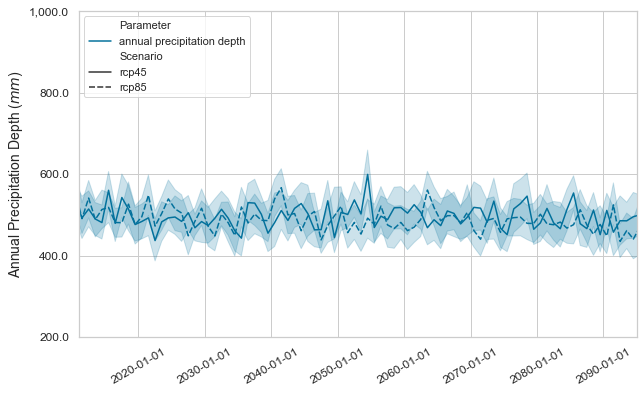

In [53]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 6.0)
ax11 = Fig1.add_subplot(111)
r1 = sns.lineplot( x="Date", y="Value", hue="Parameter",
                   style="Scenario", ci=90,
                   palette={ "annual precipitation depth" : "xkcd:ocean blue",},
                   data=sbPrecipDF, ax=ax11 )
r1.legend(prop=dict(size=12))
r1.legend(loc="upper left")
r1.grid(b=True, which="both", axis='y')
r1.set_yticks( preTicks )
r1.set_xlabel('', fontsize=12 )
r1.set_ylabel('Annual Precipitation Depth ($mm$)', fontsize=14)
r1.set_ylim( ( MinPre, MaxPre ))
r1.set_xlim( ( TP_DICT[2][0], dt.datetime( 2095, 1, 1 ) ) )
r1.tick_params(axis='both', which='major', labelsize=12)
r1.tick_params(axis='x', which='major', labelrotation=30.0)
r1.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
r1.xaxis.set_major_formatter( mpl.dates.DateFormatter("%Y-%m-%d") )
#Fig1.savefig( OutSVG )
#Fig1.savefig( OutPNG )

In [54]:
MaxT = 40.0
MinT = 10.0

In [55]:
tTicks = [ 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0 ]

In [56]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "CMIP5_LOCA64_TempEnsCone.svg" ) )
OutSVG

'C:\\Users\\nmart\\Documents\\CC_Plots\\CMIP5_LOCA64_TempEnsCone.svg'

In [57]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "CMIP5_LOCA64_TempEnsCone.png" ) )
OutPNG

'C:\\Users\\nmart\\Documents\\CC_Plots\\CMIP5_LOCA64_TempEnsCone.png'

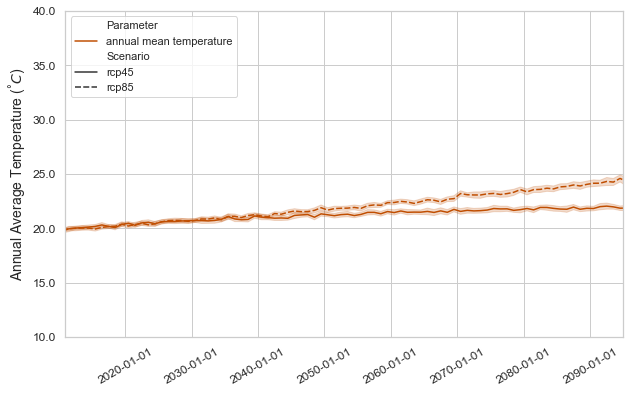

In [58]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 6.0)
ax11 = Fig1.add_subplot(111)
r1 = sns.lineplot( x="Date", y="Value", hue="Parameter",
                   style="Scenario", ci=90,
                   palette={ "annual mean temperature" : "xkcd:burnt orange",},
                   data=sbTempDF, ax=ax11 )
r1.legend(prop=dict(size=12))
r1.legend(loc="upper left")
r1.grid(b=True, which="both", axis='y')
r1.set_yticks( tTicks )
r1.set_xlabel('', fontsize=12 )
r1.set_ylabel('Annual Average Temperature ($ ^{\degree}C$)', fontsize=14)
r1.set_ylim( ( MinT, MaxT ))
r1.set_xlim( ( TP_DICT[2][0], dt.datetime( 2095, 1, 1 ) ) )
r1.tick_params(axis='both', which='major', labelsize=12)
r1.tick_params(axis='x', which='major', labelrotation=30.0)
r1.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
r1.xaxis.set_major_formatter( mpl.dates.DateFormatter("%Y-%m-%d") )
#Fig1.savefig( OutSVG )
#Fig1.savefig( OutPNG )

#### Precipitation Only

In [59]:
FAE_95.max(), FAE_5.min()

(844.032484653557, 249.9677345512049)

In [60]:
MaxEns = 1600.0
MinEns = 0.0

In [61]:
ensTicks = [ 200.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0 ]

In [62]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "AllLOCAEnsBF_Pre.svg" ) )
OutSVG

'C:\\Users\\nmart\\Documents\\CC_Plots\\AllLOCAEnsBF_Pre.svg'

In [63]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "AllLOCAEnsBF_Pre.png"  ) )
OutPNG

'C:\\Users\\nmart\\Documents\\CC_Plots\\AllLOCAEnsBF_Pre.png'

In [64]:
ACHdrs = list( PFAnnDF.columns )
S45Hdrs = list( PAnn45DF.columns )
S85Hdrs = list( PAnn85DF.columns )

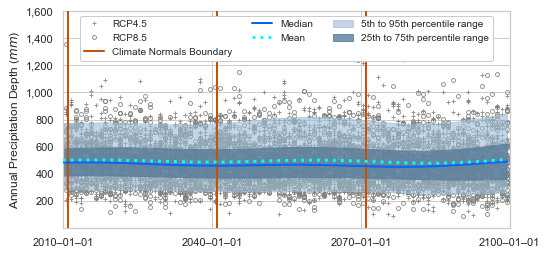

In [65]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 4.0)
ax11 = Fig1.add_subplot(111)
cCnt = 0
for tCol in S45Hdrs:
    if cCnt == 0:
        ax11.plot( PAnn45DF.index, PAnn45DF[tCol], linestyle='None', marker='+',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1, 
                   markerfacecolor='None', alpha=0.80, label="RCP4.5" )
    else:
        ax11.plot( PAnn45DF.index, PAnn45DF[tCol], linestyle='None', marker='+',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1,
                   markerfacecolor='None', alpha=0.80 )
    # end if
    cCnt += 1
# end for
cCnt = 0
for tCol in S85Hdrs:
    if cCnt == 0:
        ax11.plot( PAnn85DF.index, PAnn85DF[tCol], linestyle='None', marker='o',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1, 
                   markerfacecolor='None', alpha=0.80, label="RCP8.5" )
    else:
        ax11.plot( PAnn85DF.index, PAnn85DF[tCol], linestyle='None', marker='o',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1,
                   markerfacecolor='None', alpha=0.80 )
    # end if
    cCnt += 1
# end for
ax11.fill( DTTimeList, AEVals90, color='xkcd:light grey blue', alpha=0.6, 
           zorder=2, label="5th to 95th percentile range" )
ax11.fill( DTTimeList, AEVals50, color='xkcd:steel blue', alpha=0.8, 
           zorder=2, label="25th to 75th percentile range")
ax11.plot( [TP_DICT[2][0], TP_DICT[2][0]], [MinEns, MaxEns], linestyle='-',
           linewidth=2, color='xkcd:dark orange', zorder=3, label="Climate Normals Boundary")
ax11.plot( [TP_DICT[3][0], TP_DICT[3][0]], [MinEns, MaxEns], linestyle='-',
           linewidth=2, color='xkcd:dark orange', zorder=3)
ax11.plot( [TP_DICT[4][0], TP_DICT[4][0]], [MinEns, MaxEns], linestyle='-',
           linewidth=2, color='xkcd:dark orange', zorder=3)
ax11.plot( PFAnnDF.index, FAE_50, linestyle='-', linewidth=2, zorder=4,
           color='xkcd:bright blue', label='Median' )
ax11.plot( PFAnnDF.index, FAE_me, linestyle=':', linewidth=3, zorder=4,
           color='xkcd:cyan', label='Mean' )
ax11.set_xticks( [ dt.datetime(2010, 1, 1), dt.datetime(2040, 1, 1), dt.datetime(2070, 1, 1),
                  dt.datetime(2100, 1, 1) ] )
ax11.set_xlim( (dt.datetime(2010, 1, 1), dt.datetime(2100, 1, 1)))
ax11.set_yticks( ensTicks )
ax11.set_ylim( (MinEns, MaxEns) )
ax11.grid(True, axis='y', which='both')
ax11.set_ylabel('Annual Precipitation Depth ($mm$)', fontsize=12)
ax11.grid( b=True )
ax11.legend( loc='upper center', fontsize=10, framealpha=1.0, ncol=3 )
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%Y–%m–%d") )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )

#### Temperature Only

In [73]:
TfAE_95.max(), TfAE_5.min()

(26.210078853639853, 18.346967707248705)

In [80]:
MaxTEns = 32.0
MinTEns = 17.0

In [81]:
ensTTicks = [ 20.0, 25.0, 30.0 ]

In [82]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "AllLOCAEnsBF_Tmp.svg" ) )
OutSVG

'C:\\Users\\nmart\\Documents\\CC_Plots\\AllLOCAEnsBF_Tmp.svg'

In [83]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "AllLOCAEnsBF_Tmp.png"  ) )
OutPNG

'C:\\Users\\nmart\\Documents\\CC_Plots\\AllLOCAEnsBF_Tmp.png'

In [84]:
ACHdrs = list( TFAnnDF.columns )
S45Hdrs = list( TAnn45DF.columns )
S85Hdrs = list( TAnn85DF.columns )

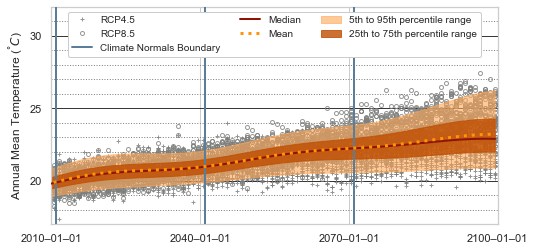

In [85]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 4.0)
ax11 = Fig1.add_subplot(111)
cCnt = 0
for tCol in S45Hdrs:
    if cCnt == 0:
        ax11.plot( TAnn45DF.index, TAnn45DF[tCol], linestyle='None', marker='+',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1, 
                   markerfacecolor='None', alpha=0.8, label="RCP4.5" )
    else:
        ax11.plot( TAnn45DF.index, TAnn45DF[tCol], linestyle='None', marker='+',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1,
                   markerfacecolor='None', alpha=0.8 )
    # end if
    cCnt += 1
# end for
cCnt = 0
for tCol in S85Hdrs:
    if cCnt == 0:
        ax11.plot( TAnn85DF.index, TAnn85DF[tCol], linestyle='None', marker='o',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1,
                   markerfacecolor='None', alpha=0.8, label="RCP8.5" )
    else:
        ax11.plot( TAnn85DF.index, TAnn85DF[tCol], linestyle='None', marker='o',
                   markersize=4.0, markeredgecolor='xkcd:medium grey', zorder=1,
                   markerfacecolor='None', alpha=0.8 )
    # end if
    cCnt += 1
# end for
ax11.plot( [TP_DICT[2][0], TP_DICT[2][0]], [MinTEns, MaxTEns], linestyle='-',
           linewidth=2, color='xkcd:steel blue', zorder=3, label="Climate Normals Boundary")
ax11.plot( [TP_DICT[3][0], TP_DICT[3][0]], [MinTEns, MaxTEns], linestyle='-',
           linewidth=2, color='xkcd:steel blue', zorder=3 )
ax11.plot( [TP_DICT[4][0], TP_DICT[4][0]], [MinTEns, MaxTEns], linestyle='-',
           linewidth=2, color='xkcd:steel blue', zorder=3 )
ax11.plot( TFAnnDF.index, TfAE_50, linestyle='-', linewidth=2, zorder=4,
           color='xkcd:brick red', label='Median' )
ax11.plot( TFAnnDF.index, TfAE_me, linestyle=':', zorder=4,
           linewidth=3, color='xkcd:tangerine', label='Mean' )
ax11.fill( DTTimeList, TaEVals90, color='xkcd:pale orange', alpha=0.6, 
                  label="5th to 95th percentile range", zorder=2 )
ax11.fill( DTTimeList, TaEVals50, color='xkcd:burnt orange', alpha=0.8, 
                  label="25th to 75th percentile range", zorder=2 )
ax11.set_xticks( [ dt.datetime(2010, 1, 1), dt.datetime(2040, 1, 1), dt.datetime(2070, 1, 1),
                  dt.datetime(2100, 1, 1) ] )
ax11.set_xlim( (dt.datetime(2010, 1, 1), dt.datetime(2100, 1, 1)))
ax11.set_ylim( (MinTEns, MaxTEns) )
ax11.set_yticks( ensTTicks )
ax11.minorticks_on()
ax11.grid(b=True, which="major", axis='y', color='xkcd:dark grey', linestyle='solid')
ax11.grid(b=True, which="minor", axis='y', color='xkcd:medium grey', linestyle='dotted')
ax11.set_ylabel('Annual Mean Temperature ($^{\degree} C$)', fontsize=12)
ax11.legend( loc='upper center', fontsize=10, framealpha=1.0, ncol=3 )
ax11.tick_params(axis='y', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%Y–%m–%d") )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )

### Combined Cones

In [ ]:
MaxEns = 1600.0
MinEns = 0.0

In [ ]:
ensTicks = [ 0.0, 200.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0 ]

In [ ]:
MaxTEns = 35.0
MinTEns = -5.0

In [ ]:
ensTTicks = [ -5.0, 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0 ]

In [ ]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "AllLOCAEns_BothCone.svg" ) )
OutSVG

In [ ]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "AllLOCAEns_BothCone.png"  ) )
OutPNG

In [ ]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.5, 6.5)
ax11 = Fig1.add_subplot(111)
pf90, = ax11.fill( DTTimeList, AEVals90, color='xkcd:light grey blue', alpha=0.6, 
                   zorder=2, label="5th to 95th percentile range" )
pf50, = ax11.fill( DTTimeList, AEVals50, color='xkcd:steel blue', alpha=0.8, 
                    zorder=2, label="25th to 75th percentile range")
pmed, = ax11.plot( PFAnnDF.index, FAE_50, linestyle='-', linewidth=2, zorder=4,
                   color='xkcd:bright blue', label='Median' )
pmean, = ax11.plot( PFAnnDF.index, FAE_me, linestyle=':', linewidth=3, zorder=4,
                    color='xkcd:cyan', label='Mean' )
ax21 = ax11.twinx()
tmed, = ax21.plot( TFAnnDF.index, TfAE_50, linestyle='-', linewidth=2, zorder=4,
                   color='xkcd:brick red', label='Median' )
tmean, = ax21.plot( TFAnnDF.index, TfAE_me, linestyle=':', zorder=4,
                    linewidth=3, color='xkcd:tangerine', label='Mean' )
tf90, = ax21.fill( DTTimeList, TaEVals90, color='xkcd:pale orange', alpha=0.6, 
                   label="5th to 95th percentile range", zorder=2 )
tf50, = ax21.fill( DTTimeList, TaEVals50, color='xkcd:burnt orange', alpha=0.8, 
                   label="25th to 75th percentile range", zorder=2 )
ax11.set_xlim( (dt.datetime(2010, 1, 1), dt.datetime(2100, 1, 1)))
ax11.set_yticks( ensTicks )
ax21.set_yticks( ensTTicks )
ax11.set_ylim( (MinEns, MaxEns) )
ax21.set_ylim( (MinTEns, MaxTEns) )
ax11.set_ylabel('Annual Precipitation Depth ($mm$)', color='xkcd:deep blue',
                fontsize=14)
ax21.set_ylabel('Annual Mean Temperature ($^{\degree} C$)', 
                color='xkcd:dark orange', fontsize=14)
ax11.grid(b=True, which='major', axis='y' )
ax11.tick_params(axis='y', which='major', labelsize=12, 
                 color='xkcd:deep blue', labelcolor='xkcd:deep blue')
ax21.tick_params(axis='y', which='major', labelsize=12, 
                 color='xkcd:dark orange', labelcolor='xkcd:dark orange')
ax11.tick_params(axis='x', which='major', labelsize=12, labelrotation=30.0)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax21.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%Y-%m-%d") )
ax21.legend( ( pmed, pmean, pf90, 
               pf50, tmed, tmean, 
               tf90, tf50, ), 
             ("Median precip.", "Mean precip.", "Precip. 5th - 95th % range", 
              "Precip. 25th - 75th % range", "Median temp.", "Mean temp.", 
              "Temp. 5th - 95th % range", "Temp. 25th - 75th % range", ),
              loc='upper center', framealpha=0.9, ncol=3, fontsize=12 )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )